In [62]:
import cv2
import numpy as np
import os
import pandas as pd
import tifffile
from matplotlib import pyplot as plt
from scipy import ndimage

### Settings

In [63]:
# File paths
dataset = "MERSCOPE_WT_1"
data_path = f"../data/{dataset}/"
output_path = f"../output/{dataset}/"

# Transformation parameters
pixel_size = 0.10799861
x_shift = int(-266.1734)
y_shift = int(180.2510)

# All DAPI images
files = os.listdir(data_path + "raw_data/DAPI_images/")
files = [i for i in files if i.startswith("mosaic")]
files.sort()
files

['mosaic_DAPI_z0.tif',
 'mosaic_DAPI_z1.tif',
 'mosaic_DAPI_z2.tif',
 'mosaic_DAPI_z3.tif',
 'mosaic_DAPI_z4.tif',
 'mosaic_DAPI_z5.tif',
 'mosaic_DAPI_z6.tif']

### Trial run: area of detected objects on the first DAPI image

In [64]:
# ==================== Helper functions ==================== #


# DoG filter
def apply_dog_filter(image, sigma=20):
    img_float = image.astype(np.float32)
    blurred = ndimage.gaussian_filter(img_float, sigma=sigma)
    dog_result = img_float - blurred
    dog_result = cv2.normalize(dog_result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return dog_result


# Thresholding followed by dilation with circular kernel
def adaptive_thresholding_with_dilation(img, block_size=49, c=-1, radius=10):
    th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, c)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    th_dilated = cv2.dilate(th, kernel)
    return th_dilated


def adaptive_thresholding_with_size_filter_and_dilation(img, block_size=49, c=-1, min_area=50, radius=10):
    th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, c)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [c for c in contours if cv2.contourArea(c) >= min_area]
    filtered_img = np.zeros_like(th)
    cv2.drawContours(filtered_img, filtered_contours, -1, 255, -1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    th_dilated = cv2.dilate(filtered_img, kernel)
    return th_dilated


def otsu_with_dilation(img, radius=10):
    _, th = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    th_dilated = cv2.dilate(th, kernel)
    return th_dilated


def dog_zero_threshold(img, sigma=20):
    dog_filtered = apply_dog_filter(img, sigma=sigma)
    _, th = cv2.threshold(dog_filtered, 0, 255, cv2.THRESH_BINARY)
    return th


def dog_zero_threshold_with_dilation(img, sigma=20, radius=10):
    dog_filtered = apply_dog_filter(img, sigma=sigma)
    _, th = cv2.threshold(dog_filtered, 0, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    th_dilated = cv2.dilate(th, kernel)
    return th_dilated


def dog_otsu(img, sigma=20):
    dog_filtered = apply_dog_filter(img, sigma=sigma)
    _, th = cv2.threshold(dog_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th


def dog_otsu_with_dilation(img, sigma=20, radius=10):
    dog_filtered = apply_dog_filter(img, sigma=sigma)
    _, th = cv2.threshold(dog_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    th_dilated = cv2.dilate(th, kernel)
    return th_dilated


# Analyze detected objects
def analyze_objects(contours, method_name):
    objects = []
    for i, contour in enumerate(contours):
        area_pixels = cv2.contourArea(contour)
        if area_pixels > 0:
            area_um2 = area_pixels * (pixel_size ** 2)
            radius_um = np.sqrt(area_um2 / np.pi)
            diameter_um = radius_um * 2
            objects.append({"method": method_name,
                            "object_id": i + 1,
                            "area_pixels": area_pixels,
                            "area_um2": area_um2,
                            "radius_um": radius_um,
                            "diameter_um": diameter_um})
    return objects


def print_method_results(objects, method_name):
    
    if len(objects) > 0:
        
        print(f"Number of detected objects: {len(objects)}")
        print(f"\nDetailed statistics for each object:")
        
        areas_px = [obj["area_pixels"] for obj in objects]
        areas_um2 = [obj["area_um2"] for obj in objects]
        radii_um = [obj["radius_um"] for obj in objects]
        diameters_um = [obj["diameter_um"] for obj in objects]
        
        print(f"\nSummary statistics:")
        print(f"  Area (pixels²):  Mean={np.mean(areas_px):6.1f}, Median={np.median(areas_px):6.1f}, Min={np.min(areas_px):6.1f}, Max={np.max(areas_px):6.1f}")
        print(f"  Area (μm²):      Mean={np.mean(areas_um2):6.2f}, Median={np.median(areas_um2):6.2f}, Min={np.min(areas_um2):6.2f}, Max={np.max(areas_um2):6.2f}")
        print(f"  Radius (μm):     Mean={np.mean(radii_um):6.2f}, Median={np.median(radii_um):6.2f}, Min={np.min(radii_um):6.2f}, Max={np.max(radii_um):6.2f}")
        print(f"  Diameter (μm):   Mean={np.mean(diameters_um):6.2f}, Median={np.median(diameters_um):6.2f}, Min={np.min(diameters_um):6.2f}, Max={np.max(diameters_um):6.2f}")
    
    else:
        
        print(f"No objects detected with {method_name}!")


# Extract statistics for plotting
def get_method_statistics(method_results, method_name, stat_type="area_pixels"):
    if method_name not in method_results:
        print(f"Method '{method_name}' not found in results")
        return []
    objects = method_results[method_name]["objects"]
    return [obj[stat_type] for obj in objects]


def get_all_methods_statistics(method_results, stat_type="area_pixels"):
    stats_dict = {}
    for method_name in method_results.keys():
        stats_dict[method_name] = get_method_statistics(method_results, method_name, stat_type)
    return stats_dict


# Downsample image
def downsample_image(img, scale_factor=5000):
    height, width = img.shape
    if height < width:
        scale_factor = 5000 / height
        new_height = 5000
        new_width = int(width * scale_factor)
    else:
        scale_factor = 5000 / width
        new_width = 5000
        new_height = int(height * scale_factor)
    return cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

In [65]:
# if len(img_downsampled.shape) == 2:
#     vis = cv2.cvtColor(img_downsampled, cv2.COLOR_GRAY2BGR)
# else:
#     vis = img_downsampled.copy()

# # Choose top-left corner of the patch (x, y)
# target_coords = [(3750, 1500), (3750, 1600), (3750, 1700)]
# w, h = 100, 100

# # Clip to image bounds (so you don't go out of range)
# for i, (x0, y0) in enumerate(target_coords):
#     H, W = vis.shape[:2]
#     x0 = max(0, min(x0, W - w))
#     y0 = max(0, min(y0, H - h))
#     thickness = 2
#     cv2.rectangle(vis, (x0, y0), (x0 + w - 1, y0 + h - 1), (0, 0, 255), thickness)
#     cv2.imwrite(output_path + f"downsampled_img_with_patch_{i}_{fname}.png", vis)

In [69]:
# Initialize for comparison
fname = files[0]

# Load DAPI image, downsample, and save representative patch
img_path = os.path.join(data_path, "raw_data/DAPI_images", fname)
img = tifffile.imread(img_path)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

img_downsampled = downsample_image(img, scale_factor=5000)
cv2.imwrite(output_path + f"downsampled_img_{fname}.png", img_downsampled)

target_coords = [(3750, 1500), (3750, 1600), (3750, 1700)]
w, h = 100, 100
for i, (x0, y0) in enumerate(target_coords):
    patch = img_downsampled[y0:y0+h, x0:x0+w]
    cv2.imwrite(output_path + f"downsampled_patch_{i}_{fname}.png", patch)

print(f"Analyzing DAPI image: {fname}")
print("="*80)

# Define thresholding methods
thresholding_methods = {
    "Adaptive Thresholding": {
        "function": lambda img: cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 49, -1),
        "description": "Gaussian-weighted adaptive thresholding with block size 49"
    },
    "Adaptive + Dilation": {
        "function": lambda img: adaptive_thresholding_with_dilation(img, block_size=49, c=-1, radius=10),
        "description": "Adaptive thresholding followed by dilation with circular kernel (radius=10px)"
    },
    "Adaptive + Size Filter + Dilation": {
        "function": lambda img: adaptive_thresholding_with_size_filter_and_dilation(img, block_size=49, c=-1, min_area=100, radius=10),
        "description": "Adaptive thresholding followed by dilation with circular kernel (radius=10px) and size filter (min_area=50px)"
    },
    "Adaptive + Size Filter + Dilation 2": {
        "function": lambda img: adaptive_thresholding_with_size_filter_and_dilation(img, block_size=49, c=-1, min_area=500, radius=10),
        "description": "Adaptive thresholding followed by dilation with circular kernel (radius=10px) and size filter (min_area=50px)"
    },
    "Otsu Thresholding": {
        "function": lambda img: cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1],
        "description": "Automatic global thresholding using Otsu's method"
    },
    "Otsu + Dilation": {
        "function": lambda img: otsu_with_dilation(img, radius=10),
        "description": "Otsu thresholding followed by dilation with circular kernel (radius=10px)"
    },
    # "DoG Zero Threshold": {
    #     "function": lambda img: dog_zero_threshold(img, sigma=20),
    #     "description": "Difference of Gaussians filter followed by zero-thresholding"
    # },
    # "DoG Zero Threshold + Dilation": {
    #     "function": lambda img: dog_zero_threshold_with_dilation(img, sigma=20, radius=10),
    #     "description": "Difference of Gaussians filter followed by zero-thresholding and dilation"
    # },
    # "DoG Otsu": {
    #     "function": lambda img: dog_otsu(img, sigma=20),
    #     "description": "Difference of Gaussians filter followed by Otsu thresholding"
    # },
    # "DoG Otsu + Dilation": {
    #     "function": lambda img: dog_otsu_with_dilation(img, sigma=20, radius=10),
    #     "description": "Difference of Gaussians filter followed by Otsu thresholding and dilation"
    # }
}

print(f"Total methods available: {list(thresholding_methods.keys())}")

# Main analysis loop
all_results = {}

for i, (method_name, method_info) in enumerate(thresholding_methods.items()):
    print(f"METHOD {i+1}: {method_name.upper()}")
    print("-" * 40)
    print(f"Description: {method_info['description']}")
    
    # Apply thresholding method
    thresholded_img = method_info["function"](img)
    
    # Find contours
    contours, _ = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Save downsampled thresholded image
    thresholded_img_downsampled = downsample_image(thresholded_img, scale_factor=5000)
    safe_filename = method_name.lower().replace(" ", "_").replace("(", "").replace(")", "").replace(",", "").replace("+", "and")
    cv2.imwrite(output_path + f"thresholded_img_{safe_filename}_downsampled.png", thresholded_img_downsampled)
    
    for i, (x0, y0) in enumerate(target_coords):
        patch = thresholded_img_downsampled[y0:y0+h, x0:x0+w]
        cv2.imwrite(output_path + f"thresholded_patch_{safe_filename}_downsampled_{i}.png", patch)
    
    # Analyze objects
    objects = analyze_objects(contours, method_name)
    
    # Print results
    print_method_results(objects, method_name)
    
    # Store results
    all_results[method_name] = {
        "objects": objects,
        "thresholded_image": thresholded_img,
        "num_objects": len(objects)
    }
    
    print("\n" + "="*80)

# Method Comparison Summary
print("COMPARISON SUMMARY")
print("-" * 40)
for method_name, results in all_results.items():
    print(f"{method_name}: {results['num_objects']} objects detected")

print("\n" + "="*80)

# Store results for further analysis
method_results = all_results

Analyzing DAPI image: mosaic_DAPI_z0.tif
Total methods available: ['Adaptive Thresholding', 'Adaptive + Dilation', 'Adaptive + Size Filter + Dilation', 'Adaptive + Size Filter + Dilation 2', 'Otsu Thresholding', 'Otsu + Dilation']
METHOD 1: ADAPTIVE THRESHOLDING
----------------------------------------
Description: Gaussian-weighted adaptive thresholding with block size 49
Number of detected objects: 1304895

Detailed statistics for each object:

Summary statistics:
  Area (pixels²):  Mean= 151.5, Median=   3.0, Min=   0.5, Max=136908.0
  Area (μm²):      Mean=  1.77, Median=  0.03, Min=  0.01, Max=1596.85
  Radius (μm):     Mean=  0.37, Median=  0.11, Min=  0.04, Max= 22.55
  Diameter (μm):   Mean=  0.74, Median=  0.21, Min=  0.09, Max= 45.09

METHOD 2: ADAPTIVE + DILATION
----------------------------------------
Description: Adaptive thresholding followed by dilation with circular kernel (radius=10px)
Number of detected objects: 387631

Detailed statistics for each object:

Summary s

In [70]:
# Example usage - extract areas and radii for each method
print("EXTRACTING STATISTICS FOR PLOTTING")
print("="*50)

# Get area statistics (pixels) for each method
areas_pixels = get_all_methods_statistics(method_results, "area_pixels")
print("Areas (pixels²) for each method:")
for method, areas in areas_pixels.items():
    print(f"  {method}: {len(areas)} objects, areas = {areas[:5]}..." if len(areas) > 5 else f"  {method}: {len(areas)} objects, areas = {areas}")

print()

# Get area statistics (μm²) for each method  
areas_um2 = get_all_methods_statistics(method_results, "area_um2")
print("Areas (μm²) for each method:")
for method, areas in areas_um2.items():
    print(f"  {method}: {len(areas)} objects, areas = {[f'{a:.2f}' for a in areas[:5]]}..." if len(areas) > 5 else f"  {method}: {len(areas)} objects, areas = {[f'{a:.2f}' for a in areas]}")

print()

# Get radius statistics (μm) for each method
radii_um = get_all_methods_statistics(method_results, "radius_um")
print("Radii (μm) for each method:")
for method, radii in radii_um.items():
    print(f"  {method}: {len(radii)} objects, radii = {[f'{r:.2f}' for r in radii[:5]]}..." if len(radii) > 5 else f"  {method}: {len(radii)} objects, radii = {[f'{r:.2f}' for r in radii]}")

print()

# Get diameter statistics (μm) for each method
diameters_um = get_all_methods_statistics(method_results, "diameter_um")
print("Diameters (μm) for each method:")
for method, diameters in diameters_um.items():
    print(f"  {method}: {len(diameters)} objects, diameters = {[f'{d:.2f}' for d in diameters[:5]]}..." if len(diameters) > 5 else f"  {method}: {len(diameters)} objects, diameters = {[f'{d:.2f}' for d in diameters]}")

print("\n" + "="*50)
print("Variables available for plotting:")
print("- areas_pixels: dict with areas in pixels² for each method")
print("- areas_um2: dict with areas in μm² for each method") 
print("- radii_um: dict with radii in μm for each method")
print("- diameters_um: dict with diameters in μm for each method")
print("\nExample access:")
print("- areas_pixels['Adaptive Thresholding'] -> list of areas")
print("- radii_um['Otsu Thresholding'] -> list of radii")

EXTRACTING STATISTICS FOR PLOTTING
Areas (pixels²) for each method:
  Adaptive Thresholding: 1304895 objects, areas = [0.5, 0.5, 1.0, 2.0, 2.5]...
  Adaptive + Dilation: 387631 objects, areas = [304.0, 304.0, 67617.0, 702.0, 875.0]...
  Adaptive + Size Filter + Dilation: 107416 objects, areas = [1449.5, 2446.5, 1906.0, 1530.5, 1993.5]...
  Adaptive + Size Filter + Dilation 2: 68769 objects, areas = [8733.5, 12205.5, 14384.0, 8282.0, 7963.0]...
  Otsu Thresholding: 83336 objects, areas = [35.5, 981.5, 1343.5, 23338.0, 1287.5]...
  Otsu + Dilation: 44126 objects, areas = [580.5, 3300.0, 33178.5, 3275.0, 16868.0]...

Areas (μm²) for each method:
  Adaptive Thresholding: 1304895 objects, areas = ['0.01', '0.01', '0.01', '0.02', '0.03']...
  Adaptive + Dilation: 387631 objects, areas = ['3.55', '3.55', '788.66', '8.19', '10.21']...
  Adaptive + Size Filter + Dilation: 107416 objects, areas = ['16.91', '28.54', '22.23', '17.85', '23.25']...
  Adaptive + Size Filter + Dilation 2: 68769 object

In [46]:
aaa = areas_um2["Adaptive + Dilation"]
np.mean(aaa), np.median(aaa)

(31.496363647077104, 6.724122912753855)

In [57]:
cutoff1 = np.percentile(aaa, 1) 
cutoff2 = np.percentile(aaa, 99.5)
bbb = [i for i in aaa if i > cutoff1 and i < cutoff2]
np.mean(bbb), np.median(bbb)

(33.9065004531169, 9.745021151094269)

In [58]:
cutoff1

3.545764727627358

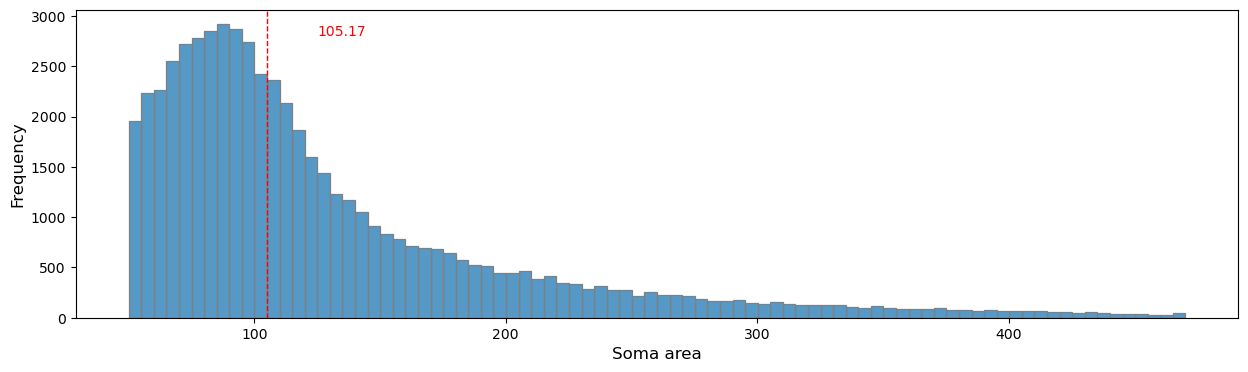

In [61]:
import seaborn as sns
ccc = [i for i in bbb if i > 50]
med = np.median(ccc)
plt.figure(figsize = (15, 4))
sns.histplot(ccc, binwidth=5, kde=False, edgecolor="gray")
if np.isfinite(med):
    plt.axvline(med, color="red", linestyle="--", linewidth=1)
    ymax = plt.ylim()[1]
    plt.text(med + 20, ymax * 0.95, f"{med:.2f}",
            color="red", ha="left", va="top", fontsize=10)
plt.xlabel("Soma area", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

In [ ]:
# Example plotting code for area/radius distributions

# Plot area distributions (μm²)
if any(len(areas) > 0 for areas in areas_um2.values()):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram comparison
    ax1.set_title("Area Distribution Comparison")
    ax1.set_xlabel("Area (μm²)")
    ax1.set_ylabel("Frequency")
    
    colors = ["blue", "orange", "green", "red", "purple"]
    for i, (method, areas) in enumerate(areas_um2.items()):
        if len(areas) > 0:
            ax1.hist(areas, alpha=0.6, label=f"{method} (n={len(areas)})", 
                    color=colors[i % len(colors)], bins=20)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Box plot comparison
    ax2.set_title("Area Distribution Box Plot")
    ax2.set_ylabel("Area (μm²)")
    
    method_names = []
    area_data = []
    for method, areas in areas_um2.items():
        if len(areas) > 0:
            method_names.append(method.replace(" Thresholding", ""))  # Shorter labels
            area_data.append(areas)
    
    if area_data:
        ax2.boxplot(area_data, labels=method_names)
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plot radius distributions (μm)
if any(len(radii) > 0 for radii in radii_um.values()):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram comparison
    ax1.set_title("Radius Distribution Comparison")
    ax1.set_xlabel("Radius (μm)")
    ax1.set_ylabel("Frequency")
    
    for i, (method, radii) in enumerate(radii_um.items()):
        if len(radii) > 0:
            ax1.hist(radii, alpha=0.6, label=f"{method} (n={len(radii)})", 
                    color=colors[i % len(colors)], bins=20)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Box plot comparison
    ax2.set_title("Radius Distribution Box Plot")
    ax2.set_ylabel("Radius (μm)")
    
    method_names = []
    radius_data = []
    for method, radii in radii_um.items():
        if len(radii) > 0:
            method_names.append(method.replace(" Thresholding", ""))
            radius_data.append(radii)
    
    if radius_data:
        ax2.boxplot(radius_data, labels=method_names)
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

print("Plots generated! You can modify the plotting code above to customize the visualizations.")

### Transcripts

In [ ]:
# Read transcripts
transcripts = pd.read_csv(data_path + "raw_data/transcripts.csv")
transcripts = transcripts[["cell_id", "gene", "global_x", "global_y", "global_z"]].copy()
transcripts.head()

In [ ]:
# Define target genes
all_genes = pd.read_csv(data_path + "processed_data/genes.csv")
all_genes = all_genes["genes"].tolist()

granule_markers = ["Camk2a", "Cplx2", "Slc17a7", "Ddn", "Syp", "Map1a", "Shank1", "Syn1", "Gria1", "Gria2", "Cyfip2", "Vamp2", "Bsn", "Slc32a1", "Nfasc", "Syt1", "Tubb3", "Nav1", "Shank3", "Mapt"]

nc_markers = pd.read_csv(data_path + "processed_data/negative_controls.csv")
nc_markers = nc_markers["Gene"].tolist()

In [ ]:
# # Main operations on transcripts

# # Compute DAPI pixel coordinates
# transcripts["row"] = (transcripts["global_y"] / pixel_size).astype(int) + y_shift
# transcripts["col"] = (transcripts["global_x"] / pixel_size).astype(int) + x_shift

# # Add default overlap column
# transcripts["overlaps_nucleus"] = 0

# # Update labels in place
# global_ratio = []

# for j, fname in enumerate(files):
    
#     # Load DAPI image
#     img = tifffile.imread(f"raw_data/DAPI_images/{fname}")
#     img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
#     # Threshold and dilate
#     th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 49, -1)
#     th = cv2.dilate(th, np.ones((3, 3), np.uint8), iterations=2)

#     # Save resized visualization (optional)
#     th_small = cv2.resize(th, (3500, 5000), interpolation=cv2.INTER_AREA)
#     cv2.imwrite(f"intermediate_data/images/z_{j}_small.png", th_small)
    
#     # Select transcripts in this z-layer
#     trans_z_mask = transcripts["global_z"] == j
#     trans_z = transcripts[trans_z_mask].copy()
#     row_vals = trans_z["row"].astype(int).values
#     col_vals = trans_z["col"].astype(int).values

#     # Avoid out-of-bounds indexing
#     height, width = th.shape
#     valid = (row_vals >= 0) & (row_vals < height) & (col_vals >= 0) & (col_vals < width)
#     row_valid = row_vals[valid]
#     col_valid = col_vals[valid]
    
#     # Assign in-nucleus labels
#     overlaps = np.zeros(len(trans_z), dtype=int)
#     overlaps[valid] = (th[row_valid, col_valid] != 0).astype(int)

#     # Update main DataFrame in-place
#     transcripts.loc[trans_z.index, "overlaps_nucleus"] = overlaps

#     # Track global ratio
#     global_ratio.append(overlaps.mean())
#     print(f"Iteration {j+1}: {np.sum(row_vals != row_valid)} row mismatches, {np.sum(col_vals != col_valid)} column mismatches, {overlaps.mean():.2%} in-nucleus")

In [ ]:
# # Final labeled transcripts
# transcripts = transcripts[["cell_id", "overlaps_nucleus", "gene", "global_x", "global_y", "global_z"]].copy()
# transcripts["global_z"] *= 1.5
# transcripts = transcripts.rename(columns = {"gene": "target"})
# transcripts.to_parquet("intermediate_data/transcripts.parquet")
# transcripts.head()

In [ ]:
# ==================== Initial Nuclei Mask Analysis (No Dilation) ====================#
# MEMORY-EFFICIENT VERSION - Copy this into your notebook cell

import gc

# Read all DAPI images from different z-layers (memory-efficient incremental processing)
print(f"Reading all DAPI images from {len(files)} z-layers...\n")

# First pass: get image dimensions
print("First pass: Getting image dimensions...")
first_img_path = os.path.join(data_path, "raw_data/DAPI_images", files[0])
first_img = tifffile.imread(first_img_path)
first_img = cv2.normalize(first_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
height, width = first_img.shape
print(f"Image shape: {height} x {width}\n")

# Initialize accumulators for memory-efficient processing
non_zero_count = np.zeros((height, width), dtype=np.uint8)
mip_accumulator = first_img.copy().astype(np.float32)
mean_accumulator = first_img.copy().astype(np.float32)
median_list = [first_img.astype(np.float32)]

# Process first image
th_first = cv2.adaptiveThreshold(first_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 49, -1)
non_zero_count += (th_first > 0).astype(np.uint8)

# Process remaining images incrementally (one at a time to save memory)
print("Processing images incrementally to save memory...")
for i, fname in enumerate(files[1:], start=1):
    print(f"  Processing layer {i+1}/{len(files)}: {fname}")
    img_path = os.path.join(data_path, "raw_data/DAPI_images", fname)
    img = tifffile.imread(img_path)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Update accumulators
    th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 49, -1)
    non_zero_count += (th > 0).astype(np.uint8)
    mip_accumulator = np.maximum(mip_accumulator, img.astype(np.float32))
    mean_accumulator += img.astype(np.float32)
    median_list.append(img.astype(np.float32))
    
    # Free memory immediately
    del img, th
    if i % 2 == 0:  # Force garbage collection every 2 images
        gc.collect()

# Finalize accumulators
mean_accumulator /= len(files)
mip_accumulator = mip_accumulator.astype(np.uint8)
mean_accumulator = mean_accumulator.astype(np.uint8)

# Compute median (still requires stacking, but only for median)
print("Computing median projection...")
median_accumulator = np.median(np.stack(median_list, axis=0), axis=0).astype(np.uint8)
del median_list, first_img, th_first
gc.collect()

print(f"Completed processing all {len(files)} images\n")
num_layers = len(files)

# Define stacking strategies (now using pre-computed accumulators)
strategies = {
    "At least 1 layer": {
        "mask": lambda: (non_zero_count >= 1).astype(np.uint8) * 255,
        "description": "Pixel is 1 if non-zero in at least 1 layer"
    },
    "At least 2 layers": {
        "mask": lambda: (non_zero_count >= 2).astype(np.uint8) * 255,
        "description": "Pixel is 1 if non-zero in at least 2 layers"
    },
    "At least 3 layers": {
        "mask": lambda: (non_zero_count >= 3).astype(np.uint8) * 255,
        "description": "Pixel is 1 if non-zero in at least 3 layers"
    },
    "At least 4 layers": {
        "mask": lambda: (non_zero_count >= 4).astype(np.uint8) * 255,
        "description": "Pixel is 1 if non-zero in at least 4 layers"
    },
    "Maximum Intensity Projection (MIP)": {
        "mask": lambda: cv2.adaptiveThreshold(
            mip_accumulator,
            255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 49, -1
        ),
        "description": "Take max across layers, then threshold"
    },
    "Mean Intensity Projection": {
        "mask": lambda: cv2.adaptiveThreshold(
            mean_accumulator,
            255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 49, -1
        ),
        "description": "Take mean across layers, then threshold"
    },
    "Median Intensity Projection": {
        "mask": lambda: cv2.adaptiveThreshold(
            median_accumulator,
            255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 49, -1
        ),
        "description": "Take median across layers, then threshold"
    }
}

# Calculate downsampling dimensions (once, since all images have same size)
if height < width:
    scale_factor = 5000 / height
    new_height = 5000
    new_width = int(width * scale_factor)
else:
    scale_factor = 5000 / width
    new_width = 5000
    new_height = int(height * scale_factor)

# Create output directory
output_dir = os.path.join(data_path, "intermediate_data")
os.makedirs(output_dir, exist_ok=True)

# Process each strategy
results = []
for strategy_name, strategy_info in strategies.items():
    print("="*80)
    print(f"STRATEGY: {strategy_name}")
    print(f"Description: {strategy_info["description"]}")
    print("="*80)
    
    # Generate merged mask
    merged_mask = strategy_info["mask"]()
    
    # Detect individual nuclei masks using findContours
    contours, _ = cv2.findContours(merged_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate areas for each detected nucleus
    nuclei_areas_pixels = []
    nuclei_areas_um2 = []
    nuclei_radii_um = []
    
    for contour in contours:
        area_pixels = cv2.contourArea(contour)
        if area_pixels > 0:  # Filter out tiny artifacts
            nuclei_areas_pixels.append(area_pixels)
            area_um2 = area_pixels * (pixel_size ** 2)
            nuclei_areas_um2.append(area_um2)
            # Approximate radius assuming circular shape: area = π * r^2
            radius_um = np.sqrt(area_um2 / np.pi)
            nuclei_radii_um.append(radius_um)
    
    # Calculate statistics
    if len(nuclei_areas_pixels) > 0:
        print(f"Number of detected nuclei: {len(nuclei_areas_pixels)}")
        print(f"\nArea statistics (pixels²):")
        print(f"  Mean: {np.mean(nuclei_areas_pixels):.1f}")
        print(f"  Median: {np.median(nuclei_areas_pixels):.1f}")
        print(f"  Min: {np.min(nuclei_areas_pixels):.1f}")
        print(f"  Max: {np.max(nuclei_areas_pixels):.1f}")
        print(f"  Std: {np.std(nuclei_areas_pixels):.1f}")
        
        print(f"\nArea statistics (μm²):")
        print(f"  Mean: {np.mean(nuclei_areas_um2):.2f}")
        print(f"  Median: {np.median(nuclei_areas_um2):.2f}")
        print(f"  Min: {np.min(nuclei_areas_um2):.2f}")
        print(f"  Max: {np.max(nuclei_areas_um2):.2f}")
        print(f"  Std: {np.std(nuclei_areas_um2):.2f}")
        
        print(f"\nRadius statistics (μm, approximated as circle):")
        print(f"  Mean: {np.mean(nuclei_radii_um):.2f}")
        print(f"  Median: {np.median(nuclei_radii_um):.2f}")
        print(f"  Min: {np.min(nuclei_radii_um):.2f}")
        print(f"  Max: {np.max(nuclei_radii_um):.2f}")
        print(f"  Std: {np.std(nuclei_radii_um):.2f}")
        
        # Store results
        results.append({
            "strategy": strategy_name,
            "num_nuclei": len(nuclei_areas_pixels),
            "mean_area_pixels": np.mean(nuclei_areas_pixels),
            "median_area_pixels": np.median(nuclei_areas_pixels),
            "mean_area_um2": np.mean(nuclei_areas_um2),
            "median_area_um2": np.median(nuclei_areas_um2),
            "mean_radius_um": np.mean(nuclei_radii_um),
            "median_radius_um": np.median(nuclei_radii_um)
        })
    else:
        print("No nuclei detected!")
        results.append({
            "strategy": strategy_name,
            "num_nuclei": 0,
            "mean_area_pixels": 0,
            "median_area_pixels": 0,
            "mean_area_um2": 0,
            "median_area_um2": 0,
            "mean_radius_um": 0,
            "median_radius_um": 0
        })
    
    # Save downsampled merged mask
    merged_mask_downsampled = cv2.resize(merged_mask, (new_width, new_height), interpolation=cv2.INTER_AREA)
    safe_filename = strategy_name.lower().replace(" ", "_").replace("(", "").replace(")", "").replace(",", "")
    output_path = os.path.join(output_dir, f"merged_mask_{safe_filename}_downsampled.png")
    cv2.imwrite(output_path, merged_mask_downsampled)
    print(f"\nDownsampled merged mask saved to: {output_path}")
    print(f"Downsampled size: {new_height} x {new_width} pixels\n")
    
    # Free memory after processing each strategy
    del merged_mask, merged_mask_downsampled, contours
    gc.collect()

# Clean up large accumulators
del non_zero_count, mip_accumulator, mean_accumulator, median_accumulator
gc.collect()

# Print summary table
print("="*80)
print("SUMMARY OF ALL STRATEGIES")
print("="*80)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print("\n" + "="*80)

# Save summary to CSV
summary_path = os.path.join(output_dir, "stacking_strategies_summary.csv")
results_df.to_csv(summary_path, index=False)
print(f"Summary saved to: {summary_path}")


In [ ]:
np.median([i for i in nuclei_areas_pixels if i > 1000])

In [ ]:
# ==================== Dilation Benchmarking ====================#

# Benchmark settings
kernel_sizes = [3, 5]
iterations_list = [2, 4, 6, 8, 10]

# Store results
results = []

print("Starting dilation benchmarking...\n")

for kernel_size in kernel_sizes:
    for iterations in iterations_list:
        print(f"Testing: {kernel_size}x{kernel_size} kernel, {iterations} iterations")
        
        # Initialize counters for this setting
        all_areas = []  # Store areas of all detected nuclei masks
        all_transcripts_overlap = []  # Track overlap for all transcripts
        granule_overlap = []  # Track overlap for granule markers
        nc_overlap = []  # Track overlap for negative controls
        
        # Process each z-layer
        for j, fname in enumerate(files):
            # Load DAPI image
            img_path = os.path.join(data_path, "raw_data/DAPI_images", fname)
            img = tifffile.imread(img_path)
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            
            # Threshold and dilate with current settings
            th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 49, -1)
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            th = cv2.dilate(th, kernel, iterations=iterations)
            
            # Detect individual nuclei masks using findContours
            contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Calculate areas for each detected nucleus
            for contour in contours:
                area_pixels = cv2.contourArea(contour)
                if area_pixels > 0:  # Filter out tiny artifacts
                    all_areas.append(area_pixels)
            
            # Map transcripts to this z-layer and check overlap
            trans_z_mask = transcripts["global_z"] == j
            trans_z = transcripts[trans_z_mask].copy()
            row_vals = trans_z["row"].astype(int).values
            col_vals = trans_z["col"].astype(int).values
            
            # Avoid out-of-bounds indexing
            height, width = th.shape
            valid = (row_vals >= 0) & (row_vals < height) & (col_vals >= 0) & (col_vals < width)
            row_valid = row_vals[valid]
            col_valid = col_vals[valid]
            
            # Check overlap for valid transcripts
            overlaps = np.zeros(len(trans_z), dtype=int)
            overlaps[valid] = (th[row_valid, col_valid] != 0).astype(int)
            
            # Store overlap information
            for idx, overlap in enumerate(overlaps):
                gene = trans_z.iloc[idx]["gene"]
                all_transcripts_overlap.append(overlap)
                
                if gene in granule_markers:
                    granule_overlap.append(overlap)
                if gene in nc_markers:
                    nc_overlap.append(overlap)
        
        # Calculate statistics
        if len(all_areas) > 0:
            avg_area_pixels = np.mean(all_areas)
            avg_area_um2 = avg_area_pixels * (pixel_size ** 2)
            # Approximate radius assuming circular shape: area = π * r^2
            avg_radius_um = np.sqrt(avg_area_um2 / np.pi)
        else:
            avg_area_pixels = 0
            avg_area_um2 = 0
            avg_radius_um = 0
        
        # Calculate extrasomatic fractions (1 - overlap fraction)
        if len(all_transcripts_overlap) > 0:
            extrasomatic_all = 1 - np.mean(all_transcripts_overlap)
        else:
            extrasomatic_all = 0
        
        if len(granule_overlap) > 0:
            extrasomatic_granule = 1 - np.mean(granule_overlap)
        else:
            extrasomatic_granule = 0
        
        if len(nc_overlap) > 0:
            extrasomatic_nc = 1 - np.mean(nc_overlap)
        else:
            extrasomatic_nc = 0
        
        # Store results
        results.append({
            "kernel_size": kernel_size,
            "iterations": iterations,
            "avg_area_pixels": avg_area_pixels,
            "avg_area_um2": avg_area_um2,
            "avg_radius_um": avg_radius_um,
            "extrasomatic_all_genes": extrasomatic_all,
            "extrasomatic_granule_markers": extrasomatic_granule,
            "extrasomatic_negative_controls": extrasomatic_nc,
            "num_nuclei": len(all_areas),
            "num_transcripts_all": len(all_transcripts_overlap),
            "num_transcripts_granule": len(granule_overlap),
            "num_transcripts_nc": len(nc_overlap)
        })
        
        print(f"  Average area: {avg_area_pixels:.1f} pixels² ({avg_area_um2:.2f} μm²), radius: {avg_radius_um:.2f} μm")
        print(f"  Extrasomatic fractions: All={extrasomatic_all:.2%}, Granule={extrasomatic_granule:.2%}, NC={extrasomatic_nc:.2%}\n")

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("BENCHMARK RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))
print("\n" + "="*80)

# Save results to CSV
results_df.to_csv(os.path.join(data_path, "intermediate_data", "dilation_benchmark_results.csv"), index=False)
print(f"\nResults saved to: {os.path.join(data_path, "intermediate_data", "dilation_benchmark_results.csv")}")